In [15]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt

In [17]:
# part of face recognition
bmp = cv.imread('facesP1.bmp',0)

In [18]:
train_img = []
train_label = []
test_img = []
test_label = []

for x in range(0,200,40):
    for y in range(0,640,40):
        if(x==160):
            test_img.append(bmp[x:x+40,y:y+40])
            test_label.append(y/40)
        else:
            train_img.append(bmp[x:x+40,y:y+40])
            train_label.append(y/40)
#flip
for x in range(0,200,40):
    for y in range(0,640,40):
            train_img.append(np.flip(bmp[x:x+40,y:y+40],axis=1))
            train_label.append(y/40)
            
train_img = np.array(train_img)
train_Y = np.array(train_label)
test_img = np.array(test_img)
test_Y = np.array(test_label)

In [19]:
train_X = train_img.reshape(train_img.shape[0],train_img.shape[1]*train_img.shape[2])
test_X = test_img.reshape(test_img.shape[0],test_img.shape[1]*test_img.shape[2])

In [21]:
def accuracy(true,pred):
    return np.sum(true==pred)/len(true)

In [22]:
# standardization data
def standardize(data):
    mean = data.mean(axis=0)
    out = data - mean
    out /= np.std(out)
    return out

In [23]:
class PCA:
    def __init__(self):
        return
    def fit(self,feature, component=2):
        feature_num = feature.shape[1]
        
        eig_vecs, eig_vals, V = np.linalg.svd(feature.T)
        self.eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
        
        self.component = np.hstack((self.eig_pairs[0][1].reshape(feature_num,1), 
                          self.eig_pairs[1][1].reshape(feature_num,1)))
        
        for i in range(2,component):
            self.component = np.hstack((self.component, self.eig_pairs[i][1].reshape(feature_num,1)))
        
    def transform(self,feature):
        return feature@self.component
    
    def get_componet(self):
        return self.component
    
    def get_eignepair(self):
        return self.eig_pairs

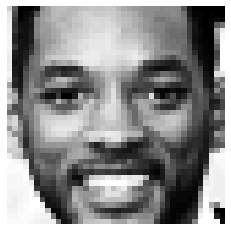

In [24]:
plt.imshow(train_X[32].reshape(40,40),cmap='gray')
plt.axis('off')
plt.show()

In [25]:
# mean face
mean = train_X.mean(axis=0)
# zero mean face 
zero_mean_train_X = train_X - mean

# Doing PCA, and get eigenface
pca = PCA()
pca.fit(zero_mean_train_X, component=90)
train_X_PCA = pca.transform(zero_mean_train_X)
eigen_pair = pca.get_eignepair()

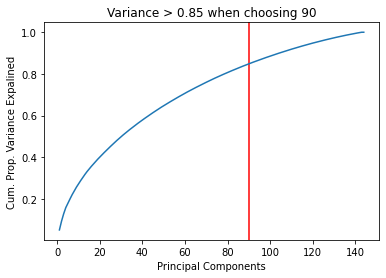

In [26]:
var_comp_sum = np.cumsum(np.array(eigen_pair)[:,0])/sum(np.array(eigen_pair)[:,0])
num_comp = range(1,len(eigen_pair)+1)
result = np.where(var_comp_sum >= 0.85)

plt.title('Variance > 0.85 when choosing {}'.format(result[0][0]))
plt.xlabel('Principal Components')
plt.ylabel('Cum. Prop. Variance Expalined')
plt.axvline(x=result[0][0], color='r', linestyle='-')
plt.plot(num_comp, var_comp_sum)
plt.show()

In [27]:
# using average weight as weight of the class
avg_weight = np.zeros([16,train_X_PCA.shape[1]])
for idx in range(len(train_X_PCA)): 
    avg_weight[idx%16] += train_X_PCA[idx]

avg_weight /= ((train_X_PCA.shape[0])/16)

In [28]:
pred = []
for idx in range(len(train_X_PCA)): 
    res = 0
    resVal = np.inf
    for i in range(16):
        if  ((train_X_PCA[idx] - avg_weight[i])**2).sum() < resVal:
            res =  i
            resVal = ((train_X_PCA[idx]- avg_weight[i])**2).sum()
    pred.append(res)
    
accuracy(train_Y,pred)

0.8125

In [29]:
zero_mean_test_X = test_X - mean
test_X_PCA = pca.transform(zero_mean_test_X)

pred = []
for idx in range(len(test_X_PCA)): 
    res = 0
    resVal = np.inf
    for i in range(16):
        if  ((test_X_PCA[idx] - avg_weight[i])**2).sum() < resVal:
            res =  i
            resVal = ((test_X_PCA[idx]- avg_weight[i])**2).sum()
    pred.append(res)
    
accuracy(test_Y,pred)

0.5